In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

##  欧拉距离计算

$$d(Q,C) = \sqrt{\sum_{i=1}^n[Q(i)-C(i)]^2}$$

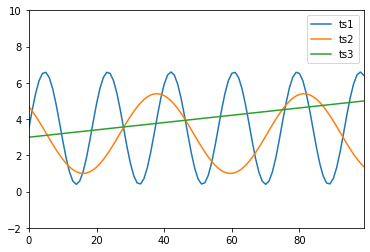

In [2]:
x = np.linspace(0,50,100)
ts1 = pd.Series(3.1*np.sin(x/1.5)+3.5)
ts2 = pd.Series(2.2*np.sin(x/3.5+2.4)+3.2)
ts3 = pd.Series(0.04*x+3.0)

ts1.plot()
ts2.plot()
ts3.plot()

plt.ylim(-2,10)
plt.legend(['ts1','ts2','ts3'])
plt.show()

In [3]:
def euclid_dist(t1,t2):
    return np.sqrt(np.sum((t1-t2)**2))

In [4]:
print(euclid_dist(ts1,ts2))

26.95921603796934


In [5]:
print(euclid_dist(ts1,ts3))

23.18924919031106


## DTW

定义两个序列Q,C分别如下所示：

$$Q=q_1,q_2,\cdots,q_n$$

$$C=c_1,c_2,\cdots,c_n$$

接着，构建一个nxn的矩阵，元素(i,j)表示$q_i$与$c_j$之间的欧拉距离。从矩阵左下角到右上角之间的路径表示为：

$$W=w_1,w_2,\cdots,w_K$$

那么,

$$w_k = (q_i,c_j)^2$$

那么，DTW算法的目标是找到一条从矩阵左下角到右上角的路径，并且该路径上的元素的累加欧拉距离最小，这样的一条路径称为warping path，表示为：

$$W^{*} = \arg\min(\sqrt{\sum_{k=1}^K w_k})$$

我们可以通过动态规划来求解这个算法：

$$\gamma(i,j) = d(q_i,c_j)+min(\gamma(i-1,j),\gamma(i,j-1),\gamma(i-1,j-1))$$

In [6]:
def DTWDistance(s1, s2):
    DTW = {}
    for i in range(len(s1)):
        DTW[(i,-1)] = float('inf') #初始化
    for j in range(len(s2)):
        DTW[(-1,j)] = float('inf')
        
    DTW[(-1,-1)] =0
    
    for i in range(len(s1)):
        for j in range(len(s2)):
            dist = (s1[i]-s2[j])**2
            DTW[(i,j)] = dist+min(DTW[(i-1,j)],DTW[(i,j-1)],DTW[(i-1,j-1)])
    
    return np.sqrt(DTW[len(s1)-1,len(s2)-1])

In [7]:
print(DTWDistance(ts1,ts2))

17.929718468641134


In [8]:
print(DTWDistance(ts1,ts3))

21.549494824404572


## DTW的提速

1. 假设$q_i$最多只能与w个$c_j$建立一对多的映射关系(0<=w<=abs(|Q|-|C|))，那么可以把DTW解空间降低。如下图所示：



In [9]:
def FastDTWDistance(s1, s2, w):
    DTW = {}
    
    w = max(w, abs(len(s1)-len(s2))) #window
    
    for i in range(-1, len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i,j)] = float('inf')
    DTW[(-1,-1)] = 0
    
    for i in range(len(s1)):
        for j in range(max(0,i-w),min(len(s2),i+w)):
            dist = (s1[i]-s2[j])**2
            DTW[(i,j)] = dist+min(DTW[(i-1,j)],DTW[(i,j-1)],DTW[(i-1,j-1)])
            
    return np.sqrt(DTW[len(s1)-1,len(s2)-1])
    
    

In [10]:
print(FastDTWDistance(ts1,ts2,10))

18.59655183841726


In [11]:
print(FastDTWDistance(ts1,ts3,10))

22.47248284679103


2. 使用lower bound LB_Keogh

这样只需要计算哪些超过U,或者低于L的时间点之间的距离之和。

$$ LBKeogh(Q,C) = \sum_{i=1}^n (c_i-U_i)^2I(c_i>U_i)+(c_i-L_i)^2I(c_i<L_i)$$

$$U_i = \max(q_{i-r}:q_{i+r})$$

$$L_i = \min(q_{i-r}:q_{i+r})$$

I(.)为指示函数

In [12]:
def LB_Keogh(s1,s2,r):
    '''
    注意：这里使用LB_KeoghEQ失效，所以使用LB_KeoghEC
    s1:Q
    s2:C
    r: windows
    '''

    LB_sum = 0
    for ind,i in enumerate(s1):
        lower_bound = min(s2[(ind-r if ind-r>=0 else 0):(ind+r if ind+r<len(s2) else len(s2))])
        upper_bound = max(s2[(ind-r if ind-r>=0 else 0):(ind+r if ind+r<len(s2) else len(s2))])
        
        if i>upper_bound:
            LB_sum = LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum = LB_sum+(i-lower_bound)**2
         
    return np.sqrt(LB_sum)
            

In [13]:
print(LB_Keogh(ts1,ts2,20))

6.253892351594148


In [14]:
print(LB_Keogh(ts1,ts3,20))

19.959547869419755


## UCR-DTW

In [2]:
import re
import math
def ConvertELogStrToValue(eLogStr):
    """
    convert string of natural logarithm base of E to value
    return (convertOK, convertedValue)
    eg:
    input:  -1.1694737e-03
    output: -0.001169
    input:  8.9455025e-04
    output: 0.000895
    """
 
    (convertOK, convertedValue) = (False, 0.0)
    foundEPower = re.search("(?P<coefficientPart>-?\d+\.\d+)e(?P<ePowerPart>[-+]\d+)", eLogStr, re.I)
    #print "foundEPower=",foundEPower
    if(foundEPower):
        coefficientPart = foundEPower.group("coefficientPart")
        ePowerPart = foundEPower.group("ePowerPart")
        #print "coefficientPart=%s,ePower=%s"%(coefficientPart, ePower)
        coefficientValue = float(coefficientPart)
        ePowerValue = float(ePowerPart)
        #print "coefficientValue=%f,ePowerValue=%f"%(coefficientValue, ePowerValue)
        #math.e= 2.71828182846
        # wholeOrigValue = coefficientValue * math.pow(math.e, ePowerValue)
        wholeOrigValue = coefficientValue * math.pow(10, ePowerValue)
 
        #print "wholeOrigValue=",wholeOrigValue;
 
        (convertOK, convertedValue) = (True, wholeOrigValue)
    else:
        (convertOK, convertedValue) = (False, 0.0)
 
    return (convertOK, convertedValue)

In [3]:
result = ConvertELogStrToValue('-1.1694737e-03')[1]

In [4]:
result = ConvertELogStrToValue('1.1607272e+000')[1]

In [5]:
print("%f" % result)

1.160727


In [22]:
import time
from collections import deque

class UCR_DTW(object):
        
    def __init__(self,data_file=None,query_file=None,m=128,R=0.05):
        self.fp = open(data_file,'r') #data file path
        self.qp = open(query_file,'r')#query file path
        self.result = open("lb_kim.result",'w')
        self.bsf = float('inf') #best-so-far
        self.m = m #the size of the query
        self.t = [None]*(self.m*2) #candidate C sequence
        self.q = [0]*self.m #query array
        self.order = [None]*self.m #new order of the query
        self.u,self.l = [None]*self.m,[None]*self.m #LB_Keogh Upper,Lower bound
        self.qo = [None]*self.m
        self.uo = [None]*self.m
        self.lo = [None]*self.m
        self.tz = [None]*self.m # 标准化后的C
        self.cb = [0]*self.m   #the cumulative lower bound
        self.cb1 = [0]*self.m  #the cumulative lower bound
        self.cb2 = [0]*self.m  #the cumulative lower bound
        self.u_d = [None]*self.m
        self.l_d = [None]*self.m
        
        """
        for every EPOCH points, all cummulative values, such as ex(sum),ex2,
        will be restarted for reducing the floating point error
        """
        self.EPOCH = 100000 #for “flush out” any accumulated floating error
        
        self.d = None #distance
        self.ex,self.ex2,self.mean,self.std = 0.0,0.0,0.0,0.0
        self.r = int(self.m*R) #LB_Keogh window,warping windows for LB_Keogh lower bound
        self.loc = 0 
        self.t1,self.t2 = None,None #start clock,end clock for time cost calculation
        self.kim = 0
        self.keogh = 0 #LB_Keogh_EQ
        self.keogh2 = 0#LB_Keogh_EC
        self.buffer = [0.0]*self.EPOCH
        self.u_buff = [0.0]*self.EPOCH
        self.l_buff = [0.0]*self.EPOCH
    
    
    def print_result(self,i):
        print("Location: ",self.loc)
        print("Distance: ",math.sqrt(self.bsf))
        print("Data Scanned: ",i)
        print("Total Execution Time: ",(self.t2-self.t1)," sec")
        print("Pruned by LB_Kim   : %.2f" % ((self.kim/i)*100),'%')
        print("Pruned by LB_Keogh : %.2f" % ((self.keogh/i)*100),'%')
        print("Pruned by LB_Keogh2: %.2f" % ((self.keogh2/i)*100),'%')
        print("DTW Calculation    : %.2f" % ((100-self.kim+self.keogh+self.keogh2)/i*100),'%')
        
    def main_run(self):
        self.t1 = time.time()#start the clock
        
        self.Q_normalize()
        #求解标准化后的Q对应的lower bound；create envelop of the query,LB_Keogh_EQ self.l and self.u
        self.lower_upper_lemire(self.q, self.m, self.r, self.l, self.u)
        
        self.sort_query_order()
        
        
        i = 0 #current index of the data in current chunk of size EPOCH
        j = 0 #the starting index of the data in the circular array, t
        it = 0 #用于表示self.buffer的长度是否为self.EPOCH,如果是，则设置为1，否则设置为0
        done = False
        while not done:      
            #read buffer of size EPOCH or when all data has been read
            ep = self.buffer_init(it)

            #data are read in chunk of size EPOCH
            #when there is nothing to read, the loop is end
            if ep<=self.m-1:
                #如果data file中的数据长度小于m-1，则直接返回，不需要进行后续的操作
                break

            #这里的buffer并没有进行normalization处理(所以，在lb_keogh_data_cumulative函数中进行标准化处理)，完整求出整个chunk中的lower bound
            self.lower_upper_lemire(self.buffer, ep, self.r, self.l_buff, self.u_buff) #LB_Keogh_EC lower bound计算
            
            #开始计算online z-normalize
            ex,ex2,mean,std = 0.0,0.0,0.0,0.0
            for i in range(ep):
                #A bunch of data has been read and pick one of them at a time to use
                d = self.buffer[i]
                #Calcualte sum and sum square
                ex += d
                ex2 += d*d
 
                #t is a circular array for keeping current data
                self.t[i%self.m] = d
                #double the size for avoiding using module "%" operator
                self.t[(i%self.m)+self.m] = d
                if i<self.m-1:
                    continue
                    
                #start the task when there are more than m-1 points in the current chunk
                #公式(5)
                mean,std = self.Compute_Mean_Std(ex, ex2)

                #候选子序列的两个索引信息
                #compute the start location of the data in the current circular array,self.t中的起始位置
                j = (i+1)%self.m
                #the start location of the data in the current chunk，在self.buffer中的位置
                I = i-(self.m-1)
                        
                #LB_KimFL
                lb_kim = self.lb_kim_hierarchy(self.t, self.q, j, self.m, mean, std, self.bsf)
                print("lb_kim:%f best_so_far:%f" % (lb_kim,self.bsf),file=self.result)
                #级联lower bound策略
                if lb_kim<self.bsf:
                    #LB_Keogh_EQ
                    lb_k = self.lb_keogh_cumulative(self.order, self.t, self.uo, self.lo, self.cb1, j, self.m, mean, std, self.bsf)
                    print("lb_k:%f best_so_far:%f" % (lb_k,self.bsf),file=self.result)
                    if lb_k<self.bsf:
                        for k in range(self.m):
                            #z-normalization of t will be computed on the fly
                            self.tz[k] = (self.t[(k+j)]-mean)/std #对完整的C序列进行标准化处理
                                
                        #LB_Keogh_EC
                        lb_k2 = self.lb_keogh_data_cumulative(self.order, self.tz, self.qo, self.cb2, self.l_buff[I:],self.u_buff[I:],self.m,mean,std, self.bsf)
                        print("lb_k2:%f best_so_far:%f" % (lb_k2,self.bsf),file=self.result)    
                        if lb_k2<self.bsf:
                            #choose better lower bound between lb_keogh and lb_keogh2 to be used in early abandoning DTW
                            #Note that cb and cb2 will be cumulative summed here
                            self.LB_Keogh_for_abandon_DTW(lb_k,lb_k2)
                            self.Early_Abandon_DTW(it,i)
                        else:
                            self.keogh2+=1
                    else:
                        self.keogh+=1
                else:
                    self.kim+=1
                        
                #reduce obsolute points from sum and sum square,公式(5)的第二项
                ex -= self.t[j]
                ex2 -= self.t[j]*self.t[j]
            if ep<self.EPOCH:
                done=True
            else:
                it+=1
            print("#"*20,it,ep,"#"*20)

        i = it*(self.EPOCH-self.m+1)+ep
        self.fp.close()
        self.result.close()
        self.t2 = time.time()
        self.print_result(i)
    
    def buffer_init(self, it):
        #read first m-1 points
        if it==0:
            #把data file中的m-1个数据读进buffer
            for k in range(self.m-1):
                try:
                    line = self.line_to_float(next(self.fp))
                    self.buffer[k] = line 
                except:
                    break
        else:
            for k in range(self.m-1):
                #把最后的m-1个时间点移到buffer的前面
                self.buffer[k] = self.buffer[self.EPOCH-self.m+1+k]
                
        #fill the rest of self.buffer
        #read buffer of size EPOCH or when all data has been read
        ep = self.m-1
        while ep<self.EPOCH:
            try:
                line = self.line_to_float(next(self.fp)) #把data file中的数据读入buffer中
                self.buffer[ep] = line
            except:
                break
            ep+=1
        return ep
    
    def Compute_Mean_Std(self, ex, ex2):
        mean = ex/self.m
        std = ex2/self.m
        std = math.sqrt(std-mean*mean)
        return mean,std
    
    def Early_Abandon_DTW(self, it, i):        
        #compute DTW and early abandoning if possible
        dist = self.dtw(self.tz, self.q, self.cb, self.m, self.r, self.bsf)
        print("dtw-dist:%f best_so_far:%f" % (dist,self.bsf),file=self.result)
        if dist<self.bsf:
            #update bsf
            #loc is the real starting locatin of the nearest neighbor in the file
            self.bsf = dist
            self.loc = it*(self.EPOCH-self.m+1)+i-self.m+1
        
    def LB_Keogh_for_abandon_DTW(self,lb_k,lb_k2):
        #结合两个LB_Keogh来进行early abandoning DTW
        if lb_k>lb_k2:
            self.cb[self.m-1] = self.cb1[self.m-1]
            for k in range(self.m-2,-1,-1):
                self.cb[k] = self.cb[k+1]+self.cb1[k]
        else:
            self.cb[self.m-1] = self.cb2[self.m-1]
            for k in range(self.m-2, -1, -1):
                self.cb[k] = self.cb[k+1]+self.cb2[k]
    
    
    def line_to_float(self, line):
        return ConvertELogStrToValue(line.strip())[1]
    
        
    def sort_query_order(self):
        """
        对标准化后的Q的所有元素取绝对值，然后对这些时间点的绝对值进行排序，获取对应的时间点索引序列
        """
        Q_tmp = {}
        #求解获取连续最大子序列的order
        #sort the query one time by abs(z-norm(q[i]))
        for i in range(self.m):
            Q_tmp[i] = abs(self.q[i])
        sorted_index = [item[0] for item in sorted(Q_tmp.items(),key=lambda x:x[1],reverse=True)]
        #also create another arrays for keeping sorted envelop
        self.order = sorted_index
        for i,ind in enumerate(sorted_index):
            self.qo[i] = self.q[ind]
            self.uo[i] = self.u[ind]
            self.lo[i] = self.l[ind]
        
        
    def Q_normalize(self):
        """
        对Query进行标准化处理
        """
        i=0
        ex = 0.0
        ex2 = 0.0
        while i<self.m:
            line = self.line_to_float(next(self.qp))
            ex += line
            ex2 += line**2
            self.q[i] = line
            i+=1
            
        #[Query z-normalize] Do z-normalize the query, keep in same array, self.q
        mean,std = self.Compute_Mean_Std(ex, ex2)
        #print("[Q_normalize]ex=%f,ex2=%f,mean=%f,std=%f"%(ex,ex2,mean,std),file=self.result)
        for i in range(self.m):
            old = self.q[i]
            self.q[i] = (self.q[i]-mean)/std
            #print("old_q[i]=%f;q[%d]=%f"%(old,i,self.q[i]),file=self.result)
        self.qp.close()
    
    
    def lower_upper_lemire(self,t,lenght,r,l,u):
        """
        Finding the envelop of min and max value for LB_Keogh_EQ
        Implementation idea is introducted by Danial Lemire in his paper
        "Faster Retrieval with a Two-Pass Dynamic-Time-Warping Lower Bound",Pattern Recognition 42(9) 2009
        参数：
            t: the query
            lenght: query lenght
            r: window
            l: lower
            u: upper
        """
        for ind in range(lenght):
            l[ind] = min(t[(ind-r if ind-r>=0 else 0):(ind+r if ind+r<lenght else lenght)])
            u[ind] = max(t[(ind-r if ind-r>=0 else 0):(ind+r if ind+r<lenght else lenght)])
        
        
    def lb_kim_hierarchy(self, t, q, j, lenght, mean, std, bsf=float('inf')):
        """
        Calculate quick lower bound
        Usually, LB_Kim take time O(m) for finding top,bottom,first and last
        however, because of z-normalization the top and bottom cannot give significant benefits
        and using the first and last points can be computed in constant time
        the prunning power of LB_Kim is non-trivial,especially when the query is not long,say in lenght 128
        参数：
            t: C-unnormalized
            q: Q-normalized
            j: t中的起始索引号
            lenght: q的长度
            mean: 均值
            std: 方差
            bsf: best-so-far
        """
        #1 point at front and back
        x0 = (t[j]-mean)/std #第一个元素进行标准化处理
        y0 = (t[(lenght-1+j)]-mean)/std #最后一个元素进行标准化处理
        #只计算first和last两个时间点之间距离之和
        lb = self.dist(x0,q[0])+self.dist(y0,q[lenght-1])
        if lb>=bsf: return lb
        
        #2 points at front
        x1 = (t[j+1]-mean)/std
        d = min(self.dist(x1,q[0]),self.dist(x0,q[1]))
        d = min(d, self.dist(x1,q[1]))
        lb += d
        if lb>=bsf: return lb
        
        #2 points at back
        y1 = (t[(lenght-2+j)]-mean)/std
        d = min(self.dist(y1,q[lenght-1]),self.dist(y0,q[lenght-2]))
        d = min(d, self.dist(y1,q[lenght-2]))
        lb += d
        if lb>=bsf: return lb
    
        #3 points at front
        x2 = (t[(j+2)]-mean)/std
        d = min(self.dist(x0,q[2]),self.dist(x1, q[2]))
        d = min(d, self.dist(x2, q[2]))
        d = min(d, self.dist(x2, q[1]))
        d = min(d, self.dist(x2, q[0]))
        lb += d
        if lb>=bsf: return lb
        
        #3 points at back
        y2 = (t[(lenght-3+j)]-mean)/std
        d = min(self.dist(y0,q[lenght-3]),self.dist(y1,q[lenght-3]))
        d = min(d, self.dist(y2,q[lenght-3]))
        d = min(d, self.dist(y2,q[lenght-2]))
        d = min(d, self.dist(y2,q[lenght-1]))
        lb += d
        
        return lb
    
    
    def lb_keogh_cumulative(self, order, t, uo, lo, cb, j, lenght, mean, std, best_so_far=float('inf')):
        """
        LB_Keogh 1: Create Envelop for the query
        Note that because the query is known, envelop can be created once at the begenining.
        
        参数：
            order: sorted indices for the query
            uo,lo: upper and lower envelops for the query,which already sorted
            t    : C (candidate subsequence) a circular array keeping the current data
            j    : index of the starting location in t
            cb   : (output)current bound at each position.It will be used later for early abandoning in DTW
        """
        lb = 0
        print("lb_keogh_cumulative:mean=%f;std=%f" % (mean,std),file=self.result)
        
        for i in range(lenght):
            if lb>=best_so_far:
                break
            
            x = (t[order[i]+j]-mean)/std #进行标准化
            d = 0
            #计算重新排序后的Q的lower bound之间的距离
            if x>uo[i]:
                d = self.dist(x, uo[i]) 
            elif x<lo[i]:
                d = self.dist(x, lo[i])
            lb += d
            cb[order[i]] = d #把每个距离都记录下来，提供给后面Early Abandoning of DTW 使用
            print("lb_keogh_cumulative:j=%d;order[i]=%d,q[order[i]]=%f;x=%f;d=%f" % (j,order[i],self.q[order[i]],x,d),file=self.result)
        return lb
    
    
    def lb_keogh_data_cumulative(self, order,tz,qo,cb,l,u,lenght,mean,std,best_so_far=float('inf')):
        '''
        LB_Keogh 2: Create Envelop for the data
        Note that the envelops have bean created (in main function) when each data point has been read.
        
        参数:
            order: 根据标准化后的Q进行的排序对应的index列表
            tz:Z-normalized C
            qo:sorted query
            cb:（cb2）current bound at each position.Used later for early abandoning in DTW
            l,u:lower and upper envelop of the current data(l_buff,u_buff)
        '''
        lb = 0
        for i in range(lenght):
            if lb>=best_so_far:
                break
            uu = (u[order[i]]-mean)/std #z-normalization，对lower bound进行标准化处理(用于应对对chunk中的所有数据进行标准化)
            ll = (l[order[i]]-mean)/std
            d = 0
            if qo[i]>uu:
                d = self.dist(qo[i],uu)
            elif qo[i]<ll:
                d = self.dist(qo[i],ll)
            lb += d
            cb[order[i]] = d
        return lb
    
    
    def dtw(self, A, B, cb, m, r, bsf=float('inf')):
        """
        Calculate Dynamic Time Wrapping distance
        A,B: data and query
        cb: cummulative bound used for early abandoning
        r: size of Sakoe-Chiba warpping band
        """
        x,y,z,min_cost = 0.0,0.0,0.0,0.0
        
        #instead of using matrix of size O(m^2) or O(mr),we will reuse two array of size O(r)
        cost = [float('inf')]*(2*r+1)
        cost_prev = [float('inf')]*(2*r+1)
        for i in range(m):
            k = max(0,r-i)
            min_cost = float('inf')
            
            for j in range(max(0,i-r),min(m-1,i+r)+1):
                #Initialize all row and column
                if i==0 and j==0:
                    cost[k] = self.dist(A[0],B[0])
                    min_cost = cost[k]
                    k+=1
                    continue
                
                if j-1<0 or k-1<0:
                    y = float('inf')
                else:
                    y = cost[k-1]
                if i-1<0 or k+1>2*r:
                    x = float('inf')
                else:
                    if i-1<0 or j-1<0:
                        z = float('inf')
                    else:
                        z = cost_prev[k]
                
                #Classic DTW calculation
                cost[k] = min(min(x,y),z)+self.dist(A[i],B[j])
                #Find minimum cost in row for early abandoning(possibly to use column instead of row)
                if cost[k]<min_cost:
                    min_cost = cost[k]
                k+=1
            
            #we can abandon early if the current cummulative distance with lower bound together are larger than bsf
            if i+r<m-1 and min_cost+cb[i+r+1]>=bsf:
                return min_cost+cb[i+r+1]
            
            #Move current array to previous array
            cost,cost_prev = cost_prev, cost
        k-=1
    
        #the DTW distance is in the last cell in the matrix of size O(m^2) or at the middle of our array
        final_dtw = cost_prev[k]
        return final_dtw
        
    def dist(self, x, y):
        return (x-y)**2

In [23]:
model = UCR_DTW('data/Data_new.txt','data/Query_new.txt')
model.main_run()

#################### 1 100000 ####################
#################### 2 100000 ####################
#################### 3 100000 ####################
#################### 4 100000 ####################
#################### 5 100000 ####################
#################### 6 100000 ####################
#################### 7 100000 ####################
#################### 8 100000 ####################
#################### 9 100000 ####################
#################### 10 100000 ####################
#################### 10 1270 ####################
Location:  347236
Distance:  7.037049413390944
Data Scanned:  1000000
Total Execution Time:  962.7777299880981  sec
Pruned by LB_Kim   : 33.47 %
Pruned by LB_Keogh : 22.52 %
Pruned by LB_Keogh2: 32.17 %
DTW Calculation    : 21.23 %


## UCR-ED

In [9]:
import time
import math

class UCR_ED(object):
    def __init__(self,input_file, query_file,m=128):
        self.fp = open(input_file,'r')
        self.qp = open(query_file,'r')
        self.m = m #length of query
        self.Q = [None]*self.m#query array
        self.T = [0.0]*(self.m*2)#array of current data
        self.order = [] #ordering of query by |z(q_i)|
        self.bsf = float('inf')
        self.loc = 0 #answer:location of the best-so-far match
        
        self.ex,self.ex2,self.mean,self.std=0.0,0.0,0.0,0.0
        #用于统计运行时间
        self.t1 = time.time()
        self.t2 = 0.0
        
        self.Q_normalize()
            
        #Sort the query data
        self.sort_query_order()
        
        #read data file, one value at a time
        ex = 0.0
        ex2 = 0.0
        i = 0
        while True:
            try:
                line = self.line_to_float(next(self.fp))
                ex += line
                ex2 += line*line
                self.T[i%m] = line
                self.T[(i%m)+m] = line
            except:
                break
            # if there is enough data in T, the ED distance can be calculated
            if i>=m-1:
                #the current starting location of T
                j = (i+1)%m
                #Z-norm(T[i]) will be calculated on the fly
                mean = ex/self.m
                std = ex2/self.m
                std = math.sqrt(std-mean*mean)

                #Calculate ED distance
                dist = self.distance(self.Q, self.T, j, self.m, mean, std, self.order, self.bsf)

                if dist<self.bsf:
                    self.bsf = dist
                    self.loc = i-m+1
                ex -= self.T[j]
                ex2 -= self.T[j]*self.T[j]
            i+=1
            
        self.fp.close()

        self.t2 = time.time()
        
        print("Location: ", self.loc)
        print("Distance: ",math.sqrt(self.bsf))
        print("Data Scanned: ", i)
        print("Total Execution Time: ",(self.t2-self.t1),' sec')
        
        
    def line_to_float(self, s):
        return ConvertELogStrToValue(s.strip())[1]
    
    
    def sort_query_order(self):
        Q_tmp = {}
        for i in range(self.m):
            Q_tmp[i] = self.Q[i]
        Q_tmp = dict(sorted(Q_tmp.items(),key=lambda x:x[1]))
        #also create another arrays for keeping sorted envelop
        self.order = list(Q_tmp.keys())
        
        
    def Q_normalize(self):
        i = 0
        ex = 0.0
        ex2 = 0.0
        while i<self.m:
            try:
                line = self.line_to_float(next(self.qp))
                ex += line
                ex2 += line*line
                self.Q[i] = line
                i+=1
            except:
                break
        self.qp.close()
        
        mean = ex/self.m
        std = ex2/self.m
        std = math.sqrt(std-mean*mean)
        
        #Do z-normalization on query data
        for i in range(self.m):
            self.Q[i] = (self.Q[i]-mean)/std
        
        
    def distance(self,Q,T,j,m,mean,std,order,bsf):
        '''
        Main function for calculating ED distance between the query Q and current data T
        Q is already sorted by absolute z-normalization value |Z-normalize(Q[i])|
        '''
        distance_sum = 0.0
        for i in range(m):
            if distance_sum>=bsf:
                break
            x = (T[order[i]+j]-mean)/std
            distance_sum += (x-Q[i])*(x-Q[i])
            
        return distance_sum

In [10]:
model = UCR_ED('data/Data_new.txt','data/Query_new.txt',128)

Location:  345511
Distance:  10.635688973132131
Data Scanned:  1000000
Total Execution Time:  26.58516502380371  sec
